In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [3]:
### RECEIVE 20,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [4]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
#     hp_regularizer = hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1), kernel_regularizer=regularizers.l2(hp_regularizer)))
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [5]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=25,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

In [6]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 2s - loss: 0.1472 - mean_squared_error: 0.1472 - val_loss: 0.1064 - val_mean_squared_error: 0.1064
Epoch 2/3
7225/7225 - 1s - loss: 0.0999 - mean_squared_error: 0.0999 - val_loss: 0.0943 - val_mean_squared_error: 0.0943
Epoch 3/3
7225/7225 - 1s - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.0935 - val_mean_squared_error: 0.0935


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 2s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 5.5420e-04 - val_mean_squared_error: 5.5420e-04
Epoch 2/3
7225/7225 - 1s - loss: 7.7594e-04 - mean_squared_error: 7.7594e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/3
7225/7225 - 1s - loss: 8.1083e-04 - mean_squared_error: 8.1083e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1299 - val_mean_squared_error: 0.1299
Epoch 2/3
7225/7225 - 1s - loss: 0.0991 - mean_squared_error: 0.0991 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 3/3
7225/7225 - 1s - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0430 - val_mean_squared_error: 0.0430


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 2/3
7225/7225 - 1s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 3/3
7225/7225 - 1s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0253 - val_mean_squared_error: 0.0253


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/3
7225/7225 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0591e-04 - val_mean_squared_error: 7.0591e-04
Epoch 3/3
7225/7225 - 1s - loss: 5.9324e-04 - mean_squared_error: 5.9324e-04 - val_loss: 8.8095e-04 - val_mean_squared_error: 8.8095e-04


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 2s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/3
7225/7225 - 1s - loss: 9.7758e-04 - mean_squared_error: 9.7758e-04 - val_loss: 9.7902e-04 - val_mean_squared_error: 9.7902e-04
Epoch 3/3
7225/7225 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.0979 - mean_squared_error: 0.0979 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 2/3
7225/7225 - 1s - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 3/3
7225/7225 - 1s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0020 - val_mean_squared_error: 0.0020


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.1262 - mean_squared_error: 0.1262 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 2/3
7225/7225 - 1s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 3/3
7225/7225 - 1s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0068 - val_mean_squared_error: 0.0068


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 5.1644e-04 - val_mean_squared_error: 5.1644e-04
Epoch 2/3
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/3
7225/7225 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0012 - val_mean_squared_error: 0.0012


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.0665 - val_mean_squared_error: 0.0665
Epoch 2/3
7225/7225 - 1s - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 3/3
7225/7225 - 1s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0062 - val_mean_squared_error: 0.0062


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.1865 - mean_squared_error: 0.1865 - val_loss: 0.1786 - val_mean_squared_error: 0.1786
Epoch 2/3
7225/7225 - 1s - loss: 0.1688 - mean_squared_error: 0.1688 - val_loss: 0.1599 - val_mean_squared_error: 0.1599
Epoch 3/3
7225/7225 - 1s - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.1381 - val_mean_squared_error: 0.1381


Train on 7225 samples, validate on 1275 samples
Epoch 1/3
7225/7225 - 1s - loss: 0.1642 - mean_squared_error: 0.1642 - val_loss: 0.1392 - val_mean_squared_error: 0.1392
Epoch 2/3
7225/7225 - 1s - loss: 0.1127 - mean_squared_error: 0.1127 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 3/3
7225/7225 - 1s - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0621 - val_mean_squared_error: 0.0621


Train on 7225 samples, validate on 1275 samples
Epoch 4/9
7225/7225 - 1s - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/9
7225/7225 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.9275e-04 - val_mean_squared_error: 6.9275e-04
Epoch 6/9
7225/7225 - 1s - loss: 5.6298e-04 - mean_squared_error: 5.6298e-04 - val_loss: 4.6736e-04 - val_mean_squared_error: 4.6736e-04
Epoch 7/9
7225/7225 - 1s - loss: 4.5655e-04 - mean_squared_error: 4.5655e-04 - val_loss: 3.9560e-04 - val_mean_squared_error: 3.9560e-04
Epoch 8/9
7225/7225 - 1s - loss: 4.6405e-04 - mean_squared_error: 4.6405e-04 - val_loss: 3.6159e-04 - val_mean_squared_error: 3.6159e-04
Epoch 9/9
7225/7225 - 1s - loss: 3.9610e-04 - mean_squared_error: 3.9610e-04 - val_loss: 3.7606e-04 - val_mean_squared_error: 3.7606e-04


Train on 7225 samples, validate on 1275 samples
Epoch 4/9
7225/7225 - 1s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 8.1172e-04 - val_mean_squared_error: 8.1172e-04
Epoch 5/9
7225/7225 - 1s - loss: 8.2586e-04 - mean_squared_error: 8.2586e-04 - val_loss: 6.4480e-04 - val_mean_squared_error: 6.4480e-04
Epoch 6/9
7225/7225 - 1s - loss: 9.1016e-04 - mean_squared_error: 9.1016e-04 - val_loss: 6.6473e-04 - val_mean_squared_error: 6.6473e-04
Epoch 7/9
7225/7225 - 1s - loss: 9.2591e-04 - mean_squared_error: 9.2591e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 8/9
7225/7225 - 1s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 9/9
7225/7225 - 1s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0059 - val_mean_squared_error: 0.0059


Train on 7225 samples, validate on 1275 samples
Epoch 4/9
7225/7225 - 2s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 6.8666e-04 - val_mean_squared_error: 6.8666e-04
Epoch 5/9
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/9
7225/7225 - 1s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/9
7225/7225 - 1s - loss: 0.1156 - mean_squared_error: 0.1156 - val_loss: 0.2204 - val_mean_squared_error: 0.2204
Epoch 8/9
7225/7225 - 1s - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2510 - val_mean_squared_error: 0.2510
Epoch 9/9
7225/7225 - 1s - loss: 0.3515 - mean_squared_error: 0.3515 - val_loss: 0.3834 - val_mean_squared_error: 0.3834


Train on 7225 samples, validate on 1275 samples
Epoch 4/9
7225/7225 - 2s - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 4.6122e-04 - val_mean_squared_error: 4.6122e-04
Epoch 5/9
7225/7225 - 1s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 7.3065e-04 - val_mean_squared_error: 7.3065e-04
Epoch 6/9
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/9
7225/7225 - 1s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 8/9
7225/7225 - 1s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 9/9
7225/7225 - 1s - loss: 0.1038 - mean_squared_error: 0.1038 - val_loss: 0.1286 - val_mean_squared_error: 0.1286


Train on 7225 samples, validate on 1275 samples
Epoch 10/25
7225/7225 - 2s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 11/25
7225/7225 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.3481e-04 - val_mean_squared_error: 7.3481e-04
Epoch 12/25
7225/7225 - 1s - loss: 5.6093e-04 - mean_squared_error: 5.6093e-04 - val_loss: 4.4594e-04 - val_mean_squared_error: 4.4594e-04
Epoch 13/25
7225/7225 - 1s - loss: 4.5738e-04 - mean_squared_error: 4.5738e-04 - val_loss: 3.8940e-04 - val_mean_squared_error: 3.8940e-04
Epoch 14/25
7225/7225 - 1s - loss: 4.6239e-04 - mean_squared_error: 4.6239e-04 - val_loss: 6.6114e-04 - val_mean_squared_error: 6.6114e-04
Epoch 15/25
7225/7225 - 1s - loss: 4.3268e-04 - mean_squared_error: 4.3268e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 16/25
7225/7225 - 1s - loss: 4.2166e-04 - mean_squared_error: 4.2166e-04 - val_loss: 4.2050e-04 - val_mean_squared_error: 4.2050e-04
Epoch 17/25

Train on 7225 samples, validate on 1275 samples
Epoch 10/25
7225/7225 - 1s - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 4.5757e-04 - val_mean_squared_error: 4.5757e-04
Epoch 11/25
7225/7225 - 1s - loss: 7.1272e-04 - mean_squared_error: 7.1272e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 12/25
7225/7225 - 1s - loss: 7.8427e-04 - mean_squared_error: 7.8427e-04 - val_loss: 6.4590e-04 - val_mean_squared_error: 6.4590e-04
Epoch 13/25
7225/7225 - 1s - loss: 7.7648e-04 - mean_squared_error: 7.7648e-04 - val_loss: 7.6121e-04 - val_mean_squared_error: 7.6121e-04
Epoch 14/25
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 15/25
7225/7225 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 16/25
7225/7225 - 1s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017


Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 2s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1286 - val_mean_squared_error: 0.1286
Epoch 2/9
7225/7225 - 1s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0701 - val_mean_squared_error: 0.0701
Epoch 3/9
7225/7225 - 1s - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 4/9
7225/7225 - 1s - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 5/9
7225/7225 - 1s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 6/9
7225/7225 - 1s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/9
7225/7225 - 1s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 8/9
7225/7225 - 1s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0025 - val_mean_square

Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 2/9
7225/7225 - 1s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/9
7225/7225 - 1s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/9
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.8714e-04 - val_mean_squared_error: 8.8714e-04
Epoch 5/9
7225/7225 - 1s - loss: 7.4235e-04 - mean_squared_error: 7.4235e-04 - val_loss: 6.3193e-04 - val_mean_squared_error: 6.3193e-04
Epoch 6/9
7225/7225 - 1s - loss: 5.7224e-04 - mean_squared_error: 5.7224e-04 - val_loss: 5.3669e-04 - val_mean_squared_error: 5.3669e-04
Epoch 7/9
7225/7225 - 1s - loss: 4.9173e-04 - mean_squared_error: 4.9173e-04 - val_loss: 4.9839e-04 - val_mean_squared_error: 4.9839e-04
Epoch 8/9
7225/7225 - 1s - loss: 4.4164e-04 - mea

Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 1s - loss: 0.1776 - mean_squared_error: 0.1776 - val_loss: 0.1636 - val_mean_squared_error: 0.1636
Epoch 2/9
7225/7225 - 1s - loss: 0.1498 - mean_squared_error: 0.1498 - val_loss: 0.1372 - val_mean_squared_error: 0.1372
Epoch 3/9
7225/7225 - 1s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1126 - val_mean_squared_error: 0.1126
Epoch 4/9
7225/7225 - 1s - loss: 0.1031 - mean_squared_error: 0.1031 - val_loss: 0.0951 - val_mean_squared_error: 0.0951
Epoch 5/9
7225/7225 - 1s - loss: 0.0890 - mean_squared_error: 0.0890 - val_loss: 0.0836 - val_mean_squared_error: 0.0836
Epoch 6/9
7225/7225 - 1s - loss: 0.0794 - mean_squared_error: 0.0794 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 7/9
7225/7225 - 1s - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 8/9
7225/7225 - 1s - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0638 - val_mean_square

Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 1s - loss: 0.1800 - mean_squared_error: 0.1800 - val_loss: 0.1630 - val_mean_squared_error: 0.1630
Epoch 2/9
7225/7225 - 1s - loss: 0.1464 - mean_squared_error: 0.1464 - val_loss: 0.1322 - val_mean_squared_error: 0.1322
Epoch 3/9
7225/7225 - 1s - loss: 0.1161 - mean_squared_error: 0.1161 - val_loss: 0.1031 - val_mean_squared_error: 0.1031
Epoch 4/9
7225/7225 - 1s - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 5/9
7225/7225 - 1s - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 6/9
7225/7225 - 1s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 7/9
7225/7225 - 1s - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 8/9
7225/7225 - 1s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0269 - val_mean_square

Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 1s - loss: 0.0984 - mean_squared_error: 0.0984 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 2/9
7225/7225 - 1s - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 3/9
7225/7225 - 1s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/9
7225/7225 - 1s - loss: 9.6548e-04 - mean_squared_error: 9.6548e-04 - val_loss: 6.4881e-04 - val_mean_squared_error: 6.4881e-04
Epoch 5/9
7225/7225 - 1s - loss: 5.3989e-04 - mean_squared_error: 5.3989e-04 - val_loss: 4.6330e-04 - val_mean_squared_error: 4.6330e-04
Epoch 6/9
7225/7225 - 1s - loss: 4.6035e-04 - mean_squared_error: 4.6035e-04 - val_loss: 4.1845e-04 - val_mean_squared_error: 4.1845e-04
Epoch 7/9
7225/7225 - 1s - loss: 4.1632e-04 - mean_squared_error: 4.1632e-04 - val_loss: 4.2422e-04 - val_mean_squared_error: 4.2422e-04
Epoch 8/9
7225/7225 - 1s - loss: 4.2395e-

Train on 7225 samples, validate on 1275 samples
Epoch 1/9
7225/7225 - 1s - loss: 0.1788 - mean_squared_error: 0.1788 - val_loss: 0.1610 - val_mean_squared_error: 0.1610
Epoch 2/9
7225/7225 - 1s - loss: 0.1434 - mean_squared_error: 0.1434 - val_loss: 0.1285 - val_mean_squared_error: 0.1285
Epoch 3/9
7225/7225 - 1s - loss: 0.1114 - mean_squared_error: 0.1114 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 4/9
7225/7225 - 1s - loss: 0.0830 - mean_squared_error: 0.0830 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 5/9
7225/7225 - 1s - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 6/9
7225/7225 - 1s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 7/9
7225/7225 - 1s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 8/9
7225/7225 - 1s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0223 - val_mean_square

Train on 7225 samples, validate on 1275 samples
Epoch 10/25
7225/7225 - 1s - loss: 0.0962 - mean_squared_error: 0.0962 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 11/25
7225/7225 - 1s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 12/25
7225/7225 - 1s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 13/25
7225/7225 - 1s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.5716e-04 - val_mean_squared_error: 6.5716e-04
Epoch 14/25
7225/7225 - 1s - loss: 5.5483e-04 - mean_squared_error: 5.5483e-04 - val_loss: 4.8355e-04 - val_mean_squared_error: 4.8355e-04
Epoch 15/25
7225/7225 - 1s - loss: 4.5693e-04 - mean_squared_error: 4.5693e-04 - val_loss: 4.1456e-04 - val_mean_squared_error: 4.1456e-04
Epoch 16/25
7225/7225 - 1s - loss: 4.1381e-04 - mean_squared_error: 4.1381e-04 - val_loss: 3.7012e-04 - val_mean_squared_error: 3.7012e-04
Epoch 17/25
7225/7225 - 1s - loss: 

Train on 7225 samples, validate on 1275 samples
Epoch 10/25
7225/7225 - 1s - loss: 0.0938 - mean_squared_error: 0.0938 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 11/25
7225/7225 - 1s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 12/25
7225/7225 - 1s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 13/25
7225/7225 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.7389e-04 - val_mean_squared_error: 9.7389e-04
Epoch 14/25
7225/7225 - 1s - loss: 7.8876e-04 - mean_squared_error: 7.8876e-04 - val_loss: 6.7860e-04 - val_mean_squared_error: 6.7860e-04
Epoch 15/25
7225/7225 - 1s - loss: 6.0248e-04 - mean_squared_error: 6.0248e-04 - val_loss: 5.3720e-04 - val_mean_squared_error: 5.3720e-04
Epoch 16/25
7225/7225 - 1s - loss: 5.0740e-04 - mean_squared_error: 5.0740e-04 - val_loss: 4.6239e-04 - val_mean_squared_error: 4.6239e-04
Epoch 17/25
7225/7225 - 1s - loss: 

Train on 7225 samples, validate on 1275 samples
Epoch 1/25
7225/7225 - 1s - loss: 0.0847 - mean_squared_error: 0.0847 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 2/25
7225/7225 - 1s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/25
7225/7225 - 1s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 8.2884e-04 - val_mean_squared_error: 8.2884e-04
Epoch 4/25
7225/7225 - 1s - loss: 6.0986e-04 - mean_squared_error: 6.0985e-04 - val_loss: 5.7184e-04 - val_mean_squared_error: 5.7184e-04
Epoch 5/25
7225/7225 - 1s - loss: 4.6842e-04 - mean_squared_error: 4.6842e-04 - val_loss: 4.2790e-04 - val_mean_squared_error: 4.2790e-04
Epoch 6/25
7225/7225 - 1s - loss: 4.4413e-04 - mean_squared_error: 4.4413e-04 - val_loss: 3.9881e-04 - val_mean_squared_error: 3.9881e-04
Epoch 7/25
7225/7225 - 1s - loss: 3.9924e-04 - mean_squared_error: 3.9924e-04 - val_loss: 4.3581e-04 - val_mean_squared_error: 4.3581e-04
Epoch 8/25
7225/7225 - 1s 

Train on 7225 samples, validate on 1275 samples
Epoch 1/25
7225/7225 - 1s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 5.3693e-04 - val_mean_squared_error: 5.3693e-04
Epoch 2/25
7225/7225 - 1s - loss: 6.4969e-04 - mean_squared_error: 6.4969e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/25
7225/7225 - 1s - loss: 9.8562e-04 - mean_squared_error: 9.8562e-04 - val_loss: 8.0618e-04 - val_mean_squared_error: 8.0618e-04
Epoch 4/25
7225/7225 - 1s - loss: 7.4395e-04 - mean_squared_error: 7.4395e-04 - val_loss: 8.2207e-04 - val_mean_squared_error: 8.2207e-04
Epoch 5/25
7225/7225 - 1s - loss: 6.6120e-04 - mean_squared_error: 6.6120e-04 - val_loss: 7.7033e-04 - val_mean_squared_error: 7.7033e-04
Epoch 6/25
7225/7225 - 1s - loss: 6.5794e-04 - mean_squared_error: 6.5794e-04 - val_loss: 6.6387e-04 - val_mean_squared_error: 6.6387e-04
Epoch 7/25
7225/7225 - 1s - loss: 9.1385e-04 - mean_squared_error: 9.1385e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014


Train on 7225 samples, validate on 1275 samples
Epoch 1/25
7225/7225 - 1s - loss: 0.0986 - mean_squared_error: 0.0986 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 2/25
7225/7225 - 1s - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 3/25
7225/7225 - 1s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/25
7225/7225 - 1s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/25
7225/7225 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/25
7225/7225 - 1s - loss: 7.2389e-04 - mean_squared_error: 7.2389e-04 - val_loss: 5.0265e-04 - val_mean_squared_error: 5.0265e-04
Epoch 7/25
7225/7225 - 1s - loss: 4.2487e-04 - mean_squared_error: 4.2487e-04 - val_loss: 3.9852e-04 - val_mean_squared_error: 3.9852e-04
Epoch 8/25
7225/7225 - 1s - loss: 4.1220e-04 - mean_squared_error:

Train on 7225 samples, validate on 1275 samples
Epoch 1/25
7225/7225 - 1s - loss: 0.0728 - mean_squared_error: 0.0728 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 2/25
7225/7225 - 1s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/25
7225/7225 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4/25
7225/7225 - 1s - loss: 8.1677e-04 - mean_squared_error: 8.1677e-04 - val_loss: 6.7380e-04 - val_mean_squared_error: 6.7380e-04
Epoch 5/25
7225/7225 - 1s - loss: 5.9107e-04 - mean_squared_error: 5.9107e-04 - val_loss: 5.1693e-04 - val_mean_squared_error: 5.1693e-04
Epoch 6/25
7225/7225 - 1s - loss: 4.8667e-04 - mean_squared_error: 4.8667e-04 - val_loss: 4.4557e-04 - val_mean_squared_error: 4.4557e-04
Epoch 7/25
7225/7225 - 1s - loss: 4.4288e-04 - mean_squared_error: 4.4288e-04 - val_loss: 4.0481e-04 - val_mean_squared_error: 4.0481e-04
Epoch 8/25
7225/7225 - 1s - loss: 

INFO:tensorflow:Oracle triggered exit
193.14425015449524


In [7]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of hidden layers are {best_hps.get('n_layers')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=40, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=2)


The hyperparameter search is complete. The optimal number of hidden layers are 1 and the optimal learning rate for the optimizer
is 0.001.

Best epoch: 31
Train on 7225 samples, validate on 1275 samples
Epoch 1/31
7225/7225 - 1s - loss: 0.0753 - mean_squared_error: 0.0753 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2/31
7225/7225 - 1s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/31
7225/7225 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/31
7225/7225 - 1s - loss: 8.2327e-04 - mean_squared_error: 8.2327e-04 - val_loss: 6.7063e-04 - val_mean_squared_error: 6.7063e-04
Epoch 5/31
7225/7225 - 1s - loss: 5.9715e-04 - mean_squared_error: 5.9715e-04 - val_loss: 5.5563e-04 - val_mean_squared_error: 5.5563e-04
Epoch 6/31
7225/7225 - 1s - loss: 4.9115e-04 - mean_squared_error: 4.9115e-04 - val_loss: 4.5678e-04 - val_mean_squared_error: 4.5678e-04
Epoch 7/31
7225/

In [8]:
# file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
# X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)[1]
print(eval_result)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 39us/sample - loss: 4.5386e-04 - mean_squared_error: 4.6050e-04
0.00046049984


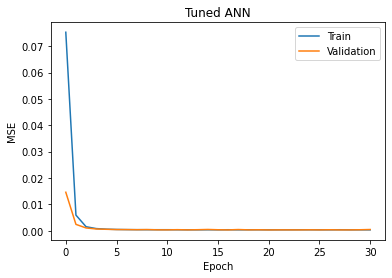

In [9]:
def visualising_data(hist, name):
    plt.title('Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.png')

In [10]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 272)               11424     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                10920     
Total params: 22,344
Trainable params: 22,344
Non-trainable params: 0
_________________________________________________________________


In [11]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

# Transfer Learning

In [12]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
#     hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
#     model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [13]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [14]:
start_time = time.time()
# new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test, verbose=0)
# evaluating OLD model with new data
hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(eval_result)
print(hypermodel_result)

22.646841764450073
[0.000126498835044913, 0.00012649882]
[0.0014548823128764828, 0.0014548821]


In [15]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_EDFAs_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
value_new = model.evaluate(X_test, Y_test, verbose=0)
# evaluating new model
value_old = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(value_new)
print(value_old)

18.60822606086731
[0.00011500731677127381, 0.00011500732]
[0.0014833107491334279, 0.0014833111]


In [16]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [17]:
hypermodel.evaluate(X_scale, Y_scale)

17000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 39us/sample - loss: 4.4590e-04 - mean_squared_error: 4.8089e-04


[0.0004808932520202635, 0.00048089324]

In [18]:
hypermodel_hist.history

{'loss': [0.07526718192111868,
  0.00592848964499561,
  0.0015262631889574462,
  0.0008232698191374631,
  0.0005971452058292925,
  0.0004911460659457016,
  0.00043688342924258803,
  0.0004104821820732103,
  0.0003962878552813302,
  0.0003909358157249406,
  0.00039504182008159535,
  0.00037532464838763987,
  0.00035616545416301945,
  0.00035131976850311493,
  0.00037531388332184314,
  0.000350593896892895,
  0.0003860221102722569,
  0.000351870408842411,
  0.00036635466334474464,
  0.00036722198987112196,
  0.0003503885683176594,
  0.0003561502258465738,
  0.00036099898833523675,
  0.0003788125403322099,
  0.00037029439887147926,
  0.0003589494671905413,
  0.000351337647185561,
  0.00038362753070378516,
  0.00035156656404680036,
  0.0003512268868004291,
  0.0003391641698887243],
 'mean_squared_error': [0.075267166,
  0.0059284926,
  0.0015262639,
  0.00082326983,
  0.0005971451,
  0.00049114606,
  0.00043688342,
  0.00041048217,
  0.0003962877,
  0.00039093586,
  0.00039504186,
  0.0003

In [19]:
def build_model(N_channels, file_path):
    X, Y = processing_data(N_channels, file_path)
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
    model = Sequential()
#     kernel_regularizer=regularizers.l2(0.00001)  - ADD THIS AT SOME POINT
    model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l1(0.000001), input_dim=N_channels+1))
    model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l1(0.000001)))
    model.add(Dense(N_channels, activation='sigmoid', kernel_regularizer=regularizers.l1(0.000001)))
    # learning_rate=0.1 causes zig-zags, learning_rate=0.0001 is far too slow
#     opt = keras.optimizers.Adam(learning_rate=0.001) - doesn't allow model to be saved as h5 model for some reason
    opt = 'adam'
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])
    # fit as we are fitting the parameters to the data
    # verbose shows how much info is shown during model fitting
    # shuffle by default set to true so this is for visual purposes
    start_time = time.time()
    hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
    training_time = time.time() - start_time
    print("Training Time: %s" % (training_time))
    return hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test

In [20]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test = build_model(N_channels, file_path)

Train on 14000 samples, validate on 3000 samples
Epoch 1/40
14000/14000 [==============================] - ETA: 3:33 - loss: 0.2032 - mean_squared_error: 0.20 - ETA: 13s - loss: 0.1897 - mean_squared_error: 0.1883 - ETA: 7s - loss: 0.1836 - mean_squared_error: 0.182 - ETA: 4s - loss: 0.1740 - mean_squared_error: 0.17 - ETA: 3s - loss: 0.1636 - mean_squared_error: 0.16 - ETA: 2s - loss: 0.1545 - mean_squared_error: 0.15 - ETA: 2s - loss: 0.1467 - mean_squared_error: 0.14 - ETA: 1s - loss: 0.1397 - mean_squared_error: 0.13 - ETA: 1s - loss: 0.1332 - mean_squared_error: 0.13 - ETA: 1s - loss: 0.1275 - mean_squared_error: 0.12 - ETA: 1s - loss: 0.1223 - mean_squared_error: 0.12 - ETA: 1s - loss: 0.1175 - mean_squared_error: 0.11 - ETA: 0s - loss: 0.1126 - mean_squared_error: 0.11 - ETA: 0s - loss: 0.1082 - mean_squared_error: 0.10 - ETA: 0s - loss: 0.1038 - mean_squared_error: 0.10 - ETA: 0s - loss: 0.0999 - mean_squared_error: 0.09 - ETA: 0s - loss: 0.0962 - mean_squared_error: 0.09 - ETA

14000/14000 [==============================] - ETA: 1s - loss: 0.0035 - mean_squared_error: 0.00 - ETA: 1s - loss: 0.0034 - mean_squared_error: 0.00 - ETA: 1s - loss: 0.0031 - mean_squared_error: 0.00 - ETA: 1s - loss: 0.0029 - mean_squared_error: 9.3666e- - ETA: 1s - loss: 0.0029 - mean_squared_error: 8.7830e- - ETA: 0s - loss: 0.0028 - mean_squared_error: 8.2080e- - ETA: 0s - loss: 0.0028 - mean_squared_error: 7.7863e- - ETA: 0s - loss: 0.0028 - mean_squared_error: 7.5279e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 7.2961e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 7.1548e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 7.0256e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.9531e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.9197e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.8288e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.7751e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.8001e- - ETA: 0s - loss: 0.0027 - mean_squared_error: 6.7121e- - ETA: 0s - los

14000/14000 [==============================] - ETA: 1s - loss: 0.0024 - mean_squared_error: 3.8325e- - ETA: 1s - loss: 0.0025 - mean_squared_error: 4.6456e- - ETA: 1s - loss: 0.0025 - mean_squared_error: 5.3151e- - ETA: 1s - loss: 0.0026 - mean_squared_error: 5.8883e- - ETA: 0s - loss: 0.0026 - mean_squared_error: 5.8163e- - ETA: 0s - loss: 0.0026 - mean_squared_error: 5.5706e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.4333e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.3805e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.2573e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.1564e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.1007e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.0479e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 4.9474e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.0531e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.0974e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.1111e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 5.0736e- - E

14000/14000 [==============================] - ETA: 1s - loss: 0.0023 - mean_squared_error: 2.9098e- - ETA: 1s - loss: 0.0024 - mean_squared_error: 4.1712e- - ETA: 1s - loss: 0.0024 - mean_squared_error: 3.9611e- - ETA: 1s - loss: 0.0024 - mean_squared_error: 4.0695e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.1314e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.1870e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.1914e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.3737e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.7714e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 4.9769e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 4.9199e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 4.9491e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.8556e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.8363e- - ETA: 0s - loss: 0.0025 - mean_squared_error: 4.8810e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.8192e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.8390e- - E

14000/14000 [==============================] - ETA: 2s - loss: 0.0022 - mean_squared_error: 2.7665e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.1303e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.0616e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.0787e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 3.9565e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.0168e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.0621e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.9815e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.9289e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.9797e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.0809e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.1128e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.1425e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.1486e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.1646e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.2112e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 4.5279e- - E

Epoch 26/40
14000/14000 [==============================] - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.3108e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 3.8163e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.0898e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 3.8544e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 3.8511e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.8617e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.8605e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.8557e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.8903e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 3.9091e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.0536e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.3764e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.4842e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5118e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5298e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5390e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 

14000/14000 [==============================] - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.5891e- - ETA: 1s - loss: 0.0022 - mean_squared_error: 3.7967e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.1203e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 5.1893e- - ETA: 0s - loss: 0.0024 - mean_squared_error: 5.0650e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.8783e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.7872e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6800e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6563e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6406e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.7093e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6529e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.7038e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6599e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6019e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5871e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5389e- - E

14000/14000 [==============================] - ETA: 1s - loss: 0.0026 - mean_squared_error: 8.1699e- - ETA: 1s - loss: 0.0023 - mean_squared_error: 4.4100e- - ETA: 1s - loss: 0.0022 - mean_squared_error: 4.1994e- - ETA: 0s - loss: 0.0022 - mean_squared_error: 4.1304e- - ETA: 0s - loss: 0.0022 - mean_squared_error: 4.1222e- - ETA: 0s - loss: 0.0022 - mean_squared_error: 4.1797e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.4419e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5513e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6629e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6506e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.6092e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5480e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5077e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.5141e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.4684e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.4169e- - ETA: 0s - loss: 0.0023 - mean_squared_error: 4.4509e- - E

In [21]:
hist.history

{'val_loss': [0.022891073688864706,
  0.00495265010635679,
  0.0029805324555685123,
  0.002846163478602345,
  0.0030415670916748546,
  0.002642792551855867,
  0.002562598088523373,
  0.0026133517233344417,
  0.002454530949316298,
  0.002438369683222845,
  0.0027450582966363677,
  0.0035638437921491762,
  0.00250020299355189,
  0.0024145809915692854,
  0.0024008141388185324,
  0.002529135332830871,
  0.0023844516575336457,
  0.0024468160957718888,
  0.0023246556577893596,
  0.0023286412380790957,
  0.0023296226797004543,
  0.002313387600549807,
  0.00232430546823889,
  0.0023135436227700364,
  0.002283666332407544,
  0.0023445130871453633,
  0.002326497777597979,
  0.0023013423355296254,
  0.002247424172392736,
  0.0022778307591409734,
  0.0022438423294418803,
  0.00229362022698236,
  0.0022225860968853035,
  0.0023947969191552452,
  0.0023061463029589503,
  0.0022065290029471118,
  0.0022394684632308782,
  0.002209079995828991,
  0.002192230706879248,
  0.0022047898406162857],
 'val_me

90th percentile mse =  0.0008987610229637139 dB


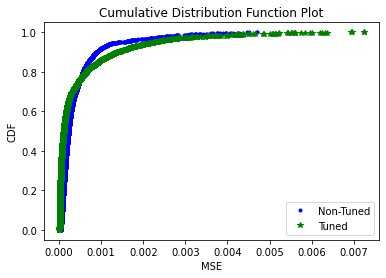

In [22]:
# name = '/Users/jackkelly/Desktop/Building_Model/Figures/Comparison.png'
# plt.title('Comparison of new and old ANN model')
# plt.plot(hypermodel_hist.history['mean_squared_error'], label='[Trained ANN] Train')
# plt.plot(hypermodel_hist.history['val_mean_squared_error'], label='[Trained ANN] Validation')
# plt.plot(hist.history['val_mean_squared_error'], label='[Non-tuned ANN] Validation')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.savefig(name)
# plt.show()

predictions = model.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store = []
for i in range(3000):
    mean_squared_error_store.append(mean_squared_error(predictions[i], Y_test[i]))
x = np.sort(mean_squared_error_store)
y = np.arange(1, len(x)+1) / len(x)

predictions_hyper = hypermodel.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store_hyper = []
for i in range(3000):
    mean_squared_error_store_hyper.append(mean_squared_error(predictions_hyper[i], Y_test[i]))
x_hyper = np.sort(mean_squared_error_store_hyper)
y_hyper = np.arange(1, len(x_hyper)+1) / len(x_hyper)


# 500 elements in mseArray so 90th percentile is 450th element
print('90th percentile mse = ', x[2700],'dB')
mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color='blue', label='Non-Tuned')
mse_ecdf = plt.plot(x_hyper, y_hyper, marker='*', linestyle='none', color='green', label='Tuned')
plt.title('Cumulative Distribution Function Plot')
plt.xlabel('MSE')
plt.ylabel('CDF')
plt.legend()
plt.savefig('CDF_initial_ann.png')
plt.show()